In [1]:
%reload_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss, f1_score
import matplotlib.pyplot as plt
import itertools
import time
import sys
from tqdm import tqdm
from fastai import *
from fastai.tabular import *
import torch
import torch.nn as nn
from imblearn.over_sampling import SMOTENC
import objgraph
import gc

In [3]:
X_train = pd.read_csv('X_train.csv', dtype = int)
X_val = pd.read_csv('X_val.csv', dtype = int)
X_test = pd.read_csv('X_test.csv', dtype = int)
y_train = pd.read_csv('y_train.csv', dtype = int)
y_val = pd.read_csv('y_val.csv', dtype = int)
#y_test = pd.read_csv('y_test.csv', dtype = int)

In [ ]:
# smotenc = SMOTENC(random_state=17, categorical_features=np.arange(16), n_jobs = 64)
# X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train,np.array(y_train).ravel())

In [ ]:
# X_train_resampled = pd.DataFrame(X_train_resampled, columns=["deaf","blind","x.rfhype5","x.rfchol1","x.asthms1","x.drdxar1","x.race","x.age.g","x.bmi5cat","x.chldcnt","x.educag","x.incomg","x.smoker3","x.ecigsts","x.rfdrhv5","x.totinda","tmp"]).drop('tmp',axis=1)

In [4]:
X_train.drop("tmp", axis = 1, inplace = True)
X_val.drop("tmp", axis = 1, inplace = True)
X_test.drop("tmp", axis = 1, inplace = True)

In [ ]:
# y_train_resampled = pd.DataFrame(y_train_resampled, columns = ['cvdinfr4'])
# y_val = pd.DataFrame(y_val, columns = ['cvdinfr4'])


In [ ]:
# y_train_resampled["cvdinfr4"].value_counts()

In [5]:
y_val["cvdinfr4"].value_counts()

0    27081
1     1780
Name: cvdinfr4, dtype: int64

In [6]:
len(X_val), len(y_val)

(28861, 28861)

In [7]:
# data_train_val = X_train_resampled.append(X_val, ignore_index = True)
# data_train_val['cvdinfr4'] = y_train_resampled.append(y_val, ignore_index = True)
# data_train_val = X_train.append(X_val, ignore_index = True)
# data_train_val['cvdinfr4'] = y_train.append(y_val, ignore_index = True)

data_train = X_train
data_train['cvdinfr4'] = y_train

data_val = X_val
data_val['cvdinfr4'] = y_val

data_train_val = data_train.append(data_val, ignore_index = True)

In [8]:
classes = ["No", "Yes"]
def plot_confusion_matrix(cm, classes=classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [12]:
procs = [Categorify, Normalize]
cat_names = ["deaf","blind","x.rfhype5","x.rfchol1","x.asthms1","x.drdxar1","x.race","x.age.g","x.bmi5cat","x.chldcnt","x.educag","x.incomg","x.smoker3","x.ecigsts","x.rfdrhv5","x.totinda"]

In [13]:
test = TabularList.from_df(X_test, path= '.', cat_names=cat_names, procs = procs)

In [14]:
d_l = (TabularList.from_df(data_train_val, path = ".", cat_names = cat_names, procs = procs)
                        .split_by_idx(valid_idx = range(len(data_train) + 1, len(data_train_val)))
                        .label_from_df(cols = 'cvdinfr4')
                        .add_test(test)
                        .databunch(bs = 2048))

In [18]:
learn = tabular_learner(d_l, [200, 100], metrics = accuracy)

In [19]:
weight = torch.FloatTensor([1, 15.23526512217449]).cuda() #15.23526512217449
learn.loss_func = nn.CrossEntropyLoss(weight = weight)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


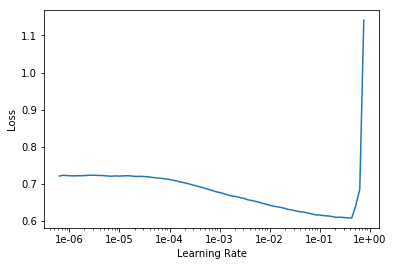

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, slice(5e-04))

epoch,train_loss,valid_loss,accuracy
1,0.582971,0.549452,0.605371
2,0.545490,0.532749,0.643209
3,0.533516,0.530265,0.666875
4,0.528620,0.528539,0.656341
5,0.528401,0.527915,0.665696


In [22]:
preds, _ = learn.get_preds(DatasetType.Test)

In [23]:
y_pred = np.array(preds).argmax(1)

[[17886  9194]
 [  356  1424]]
              precision    recall  f1-score   support

          No       0.98      0.66      0.79     27080
         Yes       0.13      0.80      0.23      1780

   micro avg       0.67      0.67      0.67     28860
   macro avg       0.56      0.73      0.51     28860
weighted avg       0.93      0.67      0.75     28860



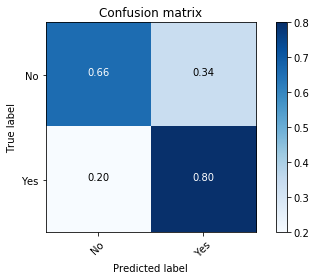

In [24]:
plt.figure()
y_test = pd.read_csv('y_test.csv', dtype = int)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), normalize = True)
print(classification_report(y_test, y_pred, target_names=classes))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


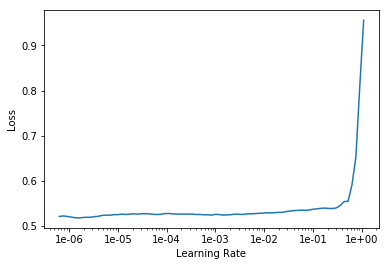

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(5, slice(1e-04))

epoch,train_loss,valid_loss,accuracy
1,0.526576,0.527915,0.674705
2,0.528436,0.528694,0.670132
3,0.528141,0.529236,0.677408
4,0.525554,0.528648,0.667325
5,0.525031,0.528613,0.663479


[[17773  9307]
 [  354  1426]]
              precision    recall  f1-score   support

          No       0.98      0.66      0.79     27080
         Yes       0.13      0.80      0.23      1780

   micro avg       0.67      0.67      0.67     28860
   macro avg       0.56      0.73      0.51     28860
weighted avg       0.93      0.67      0.75     28860



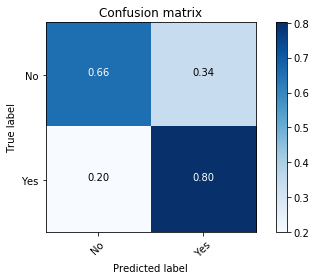

In [27]:
preds, _ = learn.get_preds(DatasetType.Test)
y_pred = np.array(preds).argmax(1)
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), normalize = True)
print(classification_report(y_test, y_pred, target_names=classes))